## Goal
Try to train MNIST on different balanced and unbalanced criterias and get good performance (~90%). Examples:
balanced - split MNIST digits into even and odd and then train it (pretty easy)
unbalanced - split MNIST into divisible by 3 and not divisible by 3 (a bit harder)

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

seed = 0
%matplotlib inline

In [2]:
# hyperparams
lr = 1e-3
lr_decay = 1e-2
bs = 32
max_iters = 2_000
eval_freq = max_iters // 10
show_freq = max_iters // 10
train_val_div = 0.9
eval_iters = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [3]:
train_set = torchvision.datasets.MNIST(root="./", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(root="./", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
X_trainval = train_set.data.float() / 255.
y_trainval = train_set.targets
X_test = (test_set.data.float() / 255.).to(device)
y_test = test_set.targets.to(device)

In [5]:
X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [6]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1-train_val_div, stratify=y_trainval, random_state=42)

# Convert to PyTorch tensors and normalize
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [7]:
def get_batch(X, y):
    idx = torch.tensor(np.random.choice(X.shape[0], size=bs, replace=False), dtype=torch.long)
    Xb = X[idx].view(-1, 1, 28, 28)
    yb = y[idx].view(-1, 1).float()
    return Xb, yb

## Predicting even or odd (?)

In [8]:
torch.manual_seed(seed)

In [9]:
y_train_oe = (y_train % 2 == 1).int()
y_val_oe = (y_val % 2 == 1).int()
y_test_oe = (y_test % 2 == 1).int()

In [10]:
@torch.no_grad()
def eval(X, y):
    model.eval()
    losses = torch.zeros(eval_iters)
    accs = torch.zeros(eval_iters)

    for i in range(eval_iters):
        Xb, yb = get_batch(X, y)
        logits = model(Xb)
        loss = criterion(logits, yb)
        acc = ((torch.sigmoid(logits) > 0.5).float() == yb).float().mean() * 100

        losses[i] = loss.item()
        accs[i] = acc.item()

    model.train()
    avg_loss = losses.mean().item()
    avg_acc = accs.mean().item()
    return avg_loss, avg_acc

In [11]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu = nn.ReLU()
        self.maxp = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(3 * 3 * 32, 1)

    def forward(self, x):
        x = self.maxp(self.relu(self.conv1(x)))
        x = self.maxp(self.relu(self.conv2(x)))
        x = self.maxp(self.relu(self.conv3(x)))
        x = x.view(-1, 3 * 3 * 32)
        x = self.fc(x)
        return x

In [12]:
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [13]:
for i in range(max_iters):
    X, y = get_batch(X_train, y_train_oe)
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % show_freq == show_freq - 1:
        train_loss, train_acc = eval(X_train, y_train_oe)
        val_loss, val_acc = eval(X_val, y_val_oe)

        print(f"Epoch: {i:5d} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Val loss: {val_loss:.4f} | Val acc: {val_acc:.2f}%")

Epoch:   199 | Train loss: 0.1517 | Train acc: 94.31% | Val loss: 0.1613 | Val acc: 94.12%
Epoch:   399 | Train loss: 0.0880 | Train acc: 96.97% | Val loss: 0.0992 | Val acc: 96.34%
Epoch:   599 | Train loss: 0.0786 | Train acc: 97.09% | Val loss: 0.0761 | Val acc: 97.25%
Epoch:   799 | Train loss: 0.0585 | Train acc: 98.19% | Val loss: 0.0644 | Val acc: 98.00%
Epoch:   999 | Train loss: 0.0580 | Train acc: 98.03% | Val loss: 0.0579 | Val acc: 97.62%
Epoch:  1199 | Train loss: 0.0724 | Train acc: 97.62% | Val loss: 0.0745 | Val acc: 97.50%
Epoch:  1399 | Train loss: 0.0572 | Train acc: 98.09% | Val loss: 0.0682 | Val acc: 97.34%
Epoch:  1599 | Train loss: 0.0450 | Train acc: 98.38% | Val loss: 0.0504 | Val acc: 98.03%
Epoch:  1799 | Train loss: 0.0479 | Train acc: 98.34% | Val loss: 0.0525 | Val acc: 98.16%
Epoch:  1999 | Train loss: 0.0565 | Train acc: 97.94% | Val loss: 0.0553 | Val acc: 97.84%


In [14]:
eval(X_train, y_train_oe)

(0.057930927723646164, 97.9375)

In [15]:
eval(X_val, y_val_oe)

(0.05892021954059601, 97.90625)

In [16]:
eval(X_test, y_test_oe)

(0.05499708652496338, 98.0625)

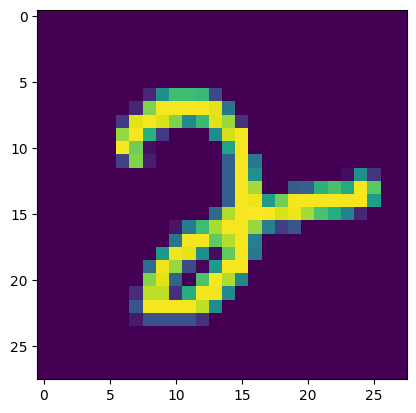

In [17]:
plt.imshow(X_train[0].cpu())

In [18]:
def predict(X):
    if X.shape[-3:] != (1, 28, 28):
        X = X.view(-1, 1, 28, 28)

    logits = model(X)
    preds = (torch.sigmoid(logits) > 0.5).int()
    if preds.shape[0] == 1:
        return preds.item()
    else:
        return preds

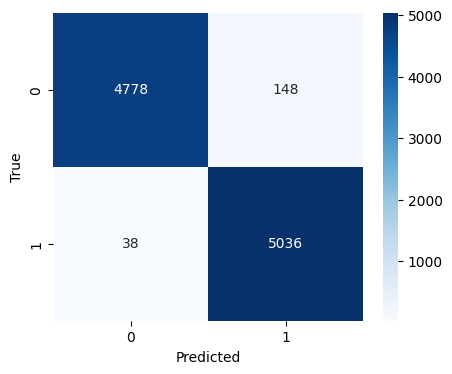

In [19]:
torch.cuda.empty_cache()
y_preds = predict(X_test).cpu()
y_true = y_test_oe.cpu()

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Predicting is 8 (?) (Highly unbalanced dataset with 10% being 1 class and 90% being the other class)

In [20]:
pos_indices_train = torch.where(y_train == 8)[0]
neg_indices_train = torch.where(y_train != 8)[0]
y_train_8 = y_train.clone()
y_train_8[pos_indices_train] = 1
y_train_8[neg_indices_train] = 0

pos_indices_val = torch.where(y_val == 8)[0]
neg_indices_val = torch.where(y_val != 8)[0]
y_val_8 = y_val.clone()
y_val_8[pos_indices_val] = 1
y_val_8[neg_indices_val] = 0

pos_indices_test = torch.where(y_test == 8)[0]
neg_indices_test = torch.where(y_test != 8)[0]
y_test_8 = y_test.clone()
y_test_8[pos_indices_test] = 1
y_test_8[neg_indices_test] = 0

In [21]:
@torch.no_grad()
def eval(X, y):
    model.eval()
    losses = torch.zeros(eval_iters)
    accs = torch.zeros(eval_iters)

    for i in range(eval_iters):
        Xb, yb = get_batch(X, y)
        logits = model(Xb)
        loss = criterion(logits, yb)
        acc = ((torch.sigmoid(logits) > 0.5).float() == yb).float().mean() * 100

        losses[i] = loss.item()
        accs[i] = acc.item()

    model.train()
    avg_loss = losses.mean().item()
    avg_acc = accs.mean().item()
    return avg_loss, avg_acc

In [22]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu = nn.ReLU()
        self.maxp = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(3 * 3 * 32, 1)

    def forward(self, x):
        x = self.maxp(self.relu(self.conv1(x)))
        x = self.maxp(self.relu(self.conv2(x)))
        x = self.maxp(self.relu(self.conv3(x)))
        x = x.view(-1, 3 * 3 * 32)
        x = self.fc(x)
        return x

## Without adding class weights

In [23]:
torch.manual_seed(seed)
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [24]:
for i in range(max_iters):
    X, y = get_batch(X_train, y_train_8)
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % show_freq == show_freq - 1:
        train_loss, train_acc = eval(X_train, y_train_8)
        val_loss, val_acc = eval(X_val, y_val_8)

        print(f"Epoch: {i:5d} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Val loss: {val_loss:.4f} | Val acc: {val_acc:.2f}%")

Epoch:   199 | Train loss: 0.2013 | Train acc: 91.38% | Val loss: 0.2024 | Val acc: 91.31%
Epoch:   399 | Train loss: 0.0777 | Train acc: 97.50% | Val loss: 0.0775 | Val acc: 97.50%
Epoch:   599 | Train loss: 0.0645 | Train acc: 98.22% | Val loss: 0.0626 | Val acc: 97.97%
Epoch:   799 | Train loss: 0.0584 | Train acc: 98.25% | Val loss: 0.0534 | Val acc: 98.31%
Epoch:   999 | Train loss: 0.0318 | Train acc: 98.94% | Val loss: 0.0306 | Val acc: 99.09%
Epoch:  1199 | Train loss: 0.0339 | Train acc: 99.03% | Val loss: 0.0326 | Val acc: 98.94%
Epoch:  1399 | Train loss: 0.0208 | Train acc: 99.25% | Val loss: 0.0190 | Val acc: 99.41%
Epoch:  1599 | Train loss: 0.0277 | Train acc: 99.12% | Val loss: 0.0173 | Val acc: 99.47%
Epoch:  1799 | Train loss: 0.0241 | Train acc: 99.16% | Val loss: 0.0185 | Val acc: 99.47%
Epoch:  1999 | Train loss: 0.0264 | Train acc: 99.12% | Val loss: 0.0234 | Val acc: 99.22%


In [25]:
eval(X_train, y_train_8)

(0.027047500014305115, 99.125)

In [26]:
eval(X_val, y_val_8)

(0.016243819147348404, 99.3125)

In [27]:
eval(X_test, y_test_8)

(0.024607572704553604, 99.28125)

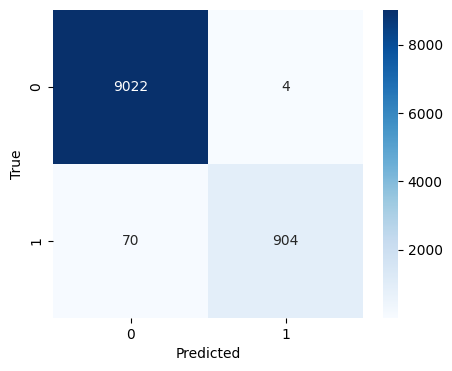

In [28]:
torch.cuda.empty_cache()
y_preds = predict(X_test).cpu()
y_true = y_test_8.cpu()

conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## With added class weights

In [29]:
torch.manual_seed(seed)
model = CNN()
unique_classes, counts = torch.unique(y_train_8, return_counts=True)
class_weights = (counts.float() / y_train_8.shape[0])**-1
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [30]:
for i in range(max_iters):
    X, y = get_batch(X_train, y_train_8)
    logits = model(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % show_freq == show_freq - 1:
        train_loss, train_acc = eval(X_train, y_train_8)
        val_loss, val_acc = eval(X_val, y_val_8)

        print(f"Epoch: {i:5d} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Val loss: {val_loss:.4f} | Val acc: {val_acc:.2f}%")

Epoch:   199 | Train loss: 0.3357 | Train acc: 96.06% | Val loss: 0.2832 | Val acc: 96.03%
Epoch:   399 | Train loss: 0.2579 | Train acc: 93.16% | Val loss: 0.2285 | Val acc: 93.62%
Epoch:   599 | Train loss: 0.1818 | Train acc: 95.56% | Val loss: 0.2090 | Val acc: 94.94%
Epoch:   799 | Train loss: 0.1252 | Train acc: 96.97% | Val loss: 0.1474 | Val acc: 96.50%
Epoch:   999 | Train loss: 0.1632 | Train acc: 95.06% | Val loss: 0.1855 | Val acc: 93.97%
Epoch:  1199 | Train loss: 0.0957 | Train acc: 98.62% | Val loss: 0.1161 | Val acc: 98.28%
Epoch:  1399 | Train loss: 0.0973 | Train acc: 97.34% | Val loss: 0.1409 | Val acc: 95.72%
Epoch:  1599 | Train loss: 0.1013 | Train acc: 98.38% | Val loss: 0.1089 | Val acc: 98.19%
Epoch:  1799 | Train loss: 0.0749 | Train acc: 99.00% | Val loss: 0.1240 | Val acc: 98.53%
Epoch:  1999 | Train loss: 0.1506 | Train acc: 94.25% | Val loss: 0.2102 | Val acc: 92.78%


In [31]:
eval(X_train, y_train_8)

(0.16160160303115845, 94.28125)

In [32]:
eval(X_val, y_val_8)

(0.19552329182624817, 93.1875)

In [33]:
eval(X_test, y_test_8)

(0.16854438185691833, 93.90625)

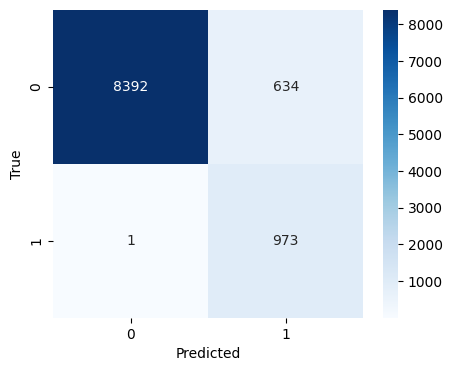

In [34]:
torch.cuda.empty_cache()
y_preds = predict(X_test).cpu()
y_true = y_test_8.cpu()

conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Conclusion
It seems like adding class weights only ruins the performance here. Not sure why. Will try to test this on harder datasets.